In [10]:

import json
from scipy.misc import imread, imresize
import os
import os.path as osp
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random
import numpy as np
from pprint import pprint
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
import six
from matplotlib import colors
colors_ = list(six.iteritems(colors.cnames))
%matplotlib inline

In [22]:
# utility functions
def smooth(ys, alpha=0.9):
    """ take a list of numbers (ys) and do exponential smoothing """
    y2 = []
    acc = None
    for y in ys:
        if acc is None:
            acc = y
        else:
            acc = alpha * acc + (1-alpha) * y
        y2.append(acc)
    return y2

number of jsons:  1
loaded  1


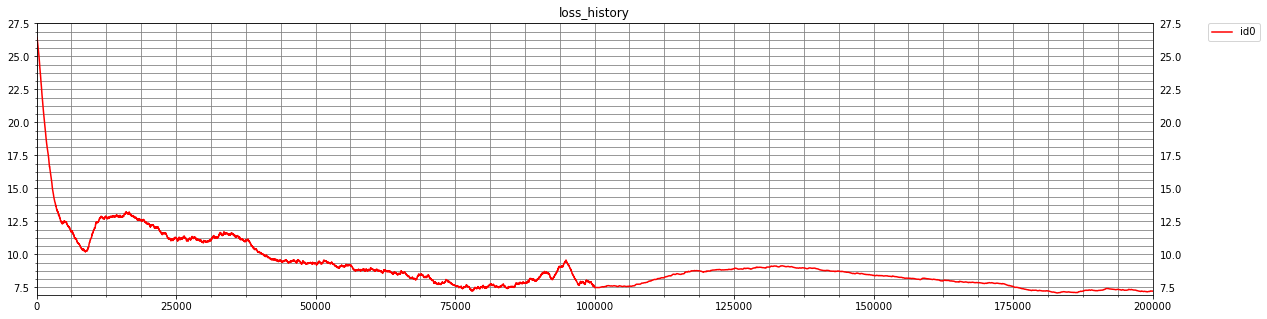

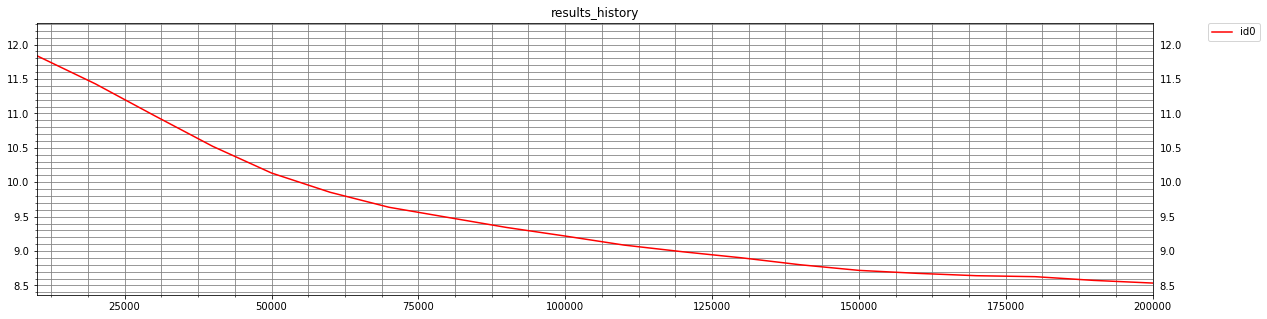

In [168]:
vg_type = 'vg_atts'
# vg_type = 'vg_objs'
files = os.listdir('../data/models/'+vg_type)
jsons = [x for x in files if x[-4:] == 'json']
print 'number of jsons: ', len(jsons)

blobs = [json.load(open(osp.join('../data/models/'+vg_type, jp))) for jp in jsons]
print 'loaded ', len(blobs)

# convert scientific string to integer number
for key in ['loss_history', 'results_history']:
    for b in blobs:
        raw_xs = b[key].keys()
        for x in raw_xs:
            b[key][int(float(x))] = b[key].pop(x)


colors = plt.cm.hsv(np.linspace(0, 1, len(jsons))).tolist()
for key in ['loss_history', 'results_history']:
    # draw the training loss functions
    plt.figure(figsize=(20,5))
    maxx = 0
    for ic, b in enumerate(blobs):
        
        xs = sorted([x for x in b[key].keys()])

        if key == 'loss_history':
            ys = [b['loss_history'][x]['total_loss'] for x in xs]
        else:
#             ys = [b['results_history'][x]['ap_results']['map'] for x in xs]
            ys = [b['results_history'][x]['loss_results']['total_loss'] for x in xs]
        ys = smooth(ys,{'loss_history':0.995, 'results_history':0.59, 'val_lang':0}[key])
        c = colors[ic]
        plt.plot(xs,ys,color=c, label='id'+str(b['opt']['id']))
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        if key == 'loss_history':
            plt.axis([min(xs), max(xs), 0.98*min(ys), 1.04*max(ys)])
        else:
            plt.axis([min(xs), max(xs), 0.98*min(ys), 1.04*max(ys)])
    plt.title(key)

    ax = plt.gca()
    ax.minorticks_on()
    ax.grid(b=True, which='both', color='gray', linestyle='-')
    ax.tick_params(axis='y', which='both', labelleft='on', labelright='on')

In [162]:
# find the best performance for each blob
# [b['results_history'][str(x)]['loss_results']['total_loss'] for x in xs]

for b in blobs:
    print(b.keys())
    xs = sorted([x for x in b[key].keys()])
    ys = [b['results_history'][x]['loss_results']['total_loss'] for x in xs]
    b['best_val'] = min(ys)

# find all the keys that were being cross-validated
keys = []
for b in blobs:
    for k in b['opt']:
        keys += [k]
ban = ['gpuid', 'seed', 'id', 'checkpoint_path']
cvd = []
for k in keys:
    if k in ban:
        continue
    # For some key, if val is different for blobs, we will check it
    
    vals = list(set([b['opt'][k] for b in blobs if k in b['opt'] and not isinstance(b['opt'][k], list) \
                    and not isinstance(b['opt'][k], bool)]))

    if len(vals) > 1:
        cvd.append(k)
        
cvd = list(set(cvd))
print 'cross-validated: '
print cvd

# print params
key_params = cvd
for ic, b in enumerate(blobs):
    print('\n id%s [%s], best_val[%.3f]' % (b['opt']['id'], colors[ic], b['best_val']))
    pprint({k:b['opt'][k] for k in b['opt'] if k in key_params})

[u'opt', u'results_history', u'loss_history', u'iter']
cross-validated: 
[]

 id0 [[1.0, 0.0, 0.0, 1.0]], best_val[8.480]
{}
